# DTSA-5511:  Week 4 - RNN Kaggle Mini Project

## Natural Language Processing with Disaster Tweets

## Part 1: Brief Description of the Problem and Data 

This project involves building a model that can predict whether a given Tweet is about a real distaster or not. This will involve building an ANN to perform binary classification of the text data. The labels will either be "1" for true or "0" for a false disaster Tweet.

The data consists of three CSV files. The first file is a training file that along with the data, also has the classification of the Tweet as true or false. The test file not surprisingly has the same data minus the classification column. Lastly, a sample submission file has also been included.

Mini Project link:
https://www.kaggle.com/competitions/nlp-getting-started/overview

In [1]:
# The below code is implemented simply to supress warnings when running this model on my system.

def import_tensorflow():
    # Filter tensorflow version warnings
    import os
    # https://stackoverflow.com/questions/40426502/is-there-a-way-to-suppress-the-messages-tensorflow-prints/40426709
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
    import warnings
    # https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=Warning)
    import tensorflow as tf
    tf.get_logger().setLevel('INFO')
    tf.autograph.set_verbosity(0)
    import logging
    tf.get_logger().setLevel(logging.ERROR)
    return tf

tf = import_tensorflow()    

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import tensorflow.keras as keras
import time
import itertools
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, BatchNormalization, Activation, LSTM, CuDNNLSTM, Embedding, Dropout
from keras.optimizers import Adam, RMSprop

# To stop pandas from truncating lists
pd.options.display.max_rows = 4000

# for text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# for model training
from sklearn.model_selection import train_test_split

In [59]:
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('averaged_perceptron_tagger')

In [4]:
print(f"TensorFlow version = {tf.__version__}\n")

TensorFlow version = 2.12.0



In [5]:
# Detect the presence of the GPU on this system. Also limit the memory growth to avoid having the model consume all the system memory.

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print("NVidia CUDA GPU information:\n")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        print(gpus)
        print("\n")
        #!nvidia-smi
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

NVidia CUDA GPU information:

1 Physical GPUs, 1 Logical GPUs
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]




## Part 2: Exploratory Data Analysis (EDA)

Connect the model to the data directories on this system.

In [6]:
base_dir = './Data'

data_train = pd.read_csv(f'{base_dir}/train.csv')
data_test = pd.read_csv(f'{base_dir}/test.csv')

We will first begin by examining the train dataset. Looking at the shape, we can see that the set contains 7613 observations with 5 pieces of data.

In [7]:
data_train.shape

(7613, 5)

Now let us take a look at the dataset itself.  

In [8]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [9]:
data_train.head(20)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


From the competition page on Kaggle, this is the summary of each category of the data categories.

| Column Name | Description                                                          |
| ----------- | -------------------------------------------------------------------- |
| id          | A unique identifier for each tweet                                   | 
| keyword     | A particular keyword from the tweet (may be blank)                   |
| location    | The location the tweet was sent from (may be blank)                  |
| text        | The text of the tweet                                                |
| target      | The denotes whether a tweet is about a real disaster (1) or not (0)  |

We will now check for the counts of null values in each category. Notice that "keyword" has a extremely small count of null values. However, location has an extremly high count (approximately 33% of the total).

In [10]:
# prints number of null values detected by .isnull() and string none
a = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.','', ' ', '   ']
for c in data_train.columns:
    string_null = np.array([x in a[2:] for x in data_train[c]])
    print(c, data_train[c].isnull().sum() + string_null.sum()) 

id 0
keyword 61
location 2537
text 0
target 0


Location should probably be removed from the dataset. However, before doing so, let us take a look at the values present in this category.

In [62]:
'''
**NOTE: This is cell is commented out for submission to GitHub. since this is a really long list. 
You can implement scrolling when running the notebook in Jupyter. However this is not a 
feature in GitHub.
'''

#unique = data_train.location.unique()

#[print(x) for x in unique] 

'\n**NOTE: This is cell is commented out for submission to GitHub. since this is a really long list. \nYou can implement scrolling when running the notebook in Jupyter. However this is not a \nfeature in GitHub.\n'

That is quite the list of locations. It has everything from city names to "live on webcam". Again for curiosity sake, let us look at the top 20 locations.

This data seems to be fairly inconsistent. Sometimes countries are listed, sometimes cities. And again to repeat, sometimes the location is simply "live on webcam". Although for the moment we will leave location in the frame, this is a strong candidate to be removed.

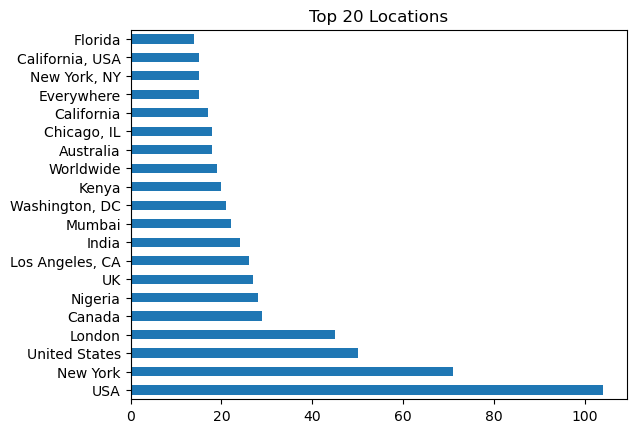

In [12]:
data_train.location.value_counts()[:20].plot(kind='barh', title='Top 20 Locations')
plt.show()

Now let us take a look at the "keyword" category to see of the observed data.

In [61]:
'''
**NOTE: This is cell is commented out for submission to GitHub. since this is a really long list. 
You can implement scrolling when running the notebook in Jupyter. However this is not a 
feature in GitHub.
'''

#unique = data_train.keyword.unique()

#[print(x) for x in unique] 

'\n**NOTE: This is cell is commented out for submission to GitHub. since this is a really long list. \nYou can implement scrolling when running the notebook in Jupyter. However this is not a \nfeature in GitHub.\n'

Now let us look at the top 20 keywords for both "non-disaster" and "disaster" Tweets.

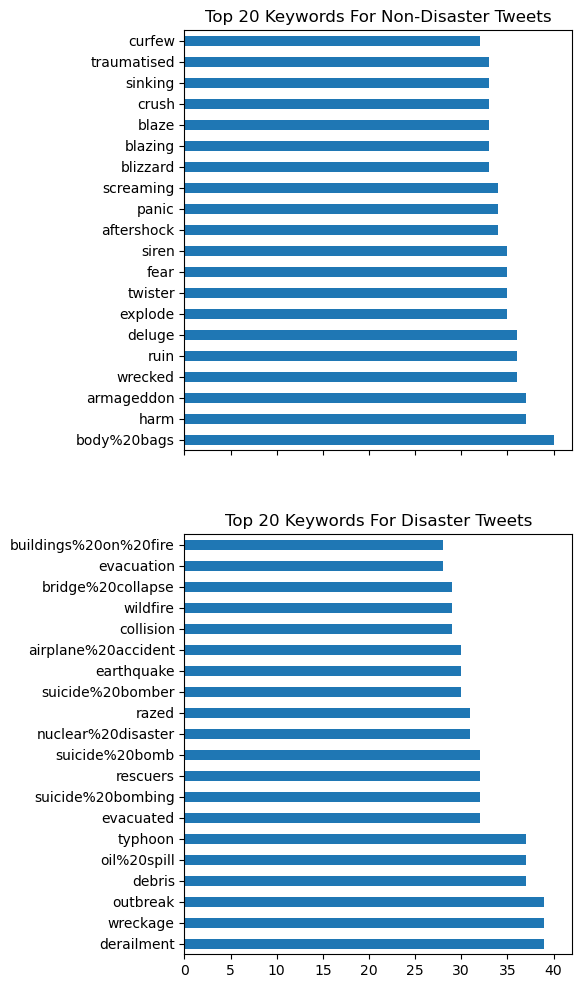

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(5, 12), sharex=True)

data_train[data_train.target == 0].keyword.value_counts()[:20].plot(kind='barh', title='Top 20 Keywords For Non-Disaster Tweets', ax=ax[0])
data_train[data_train.target == 1].keyword.value_counts()[:20].plot(kind='barh', title='Top 20 Keywords For Disaster Tweets', ax=ax[1])

plt.show()

Looking at these top 20 keywords, it is hard to distinguish in many of the cases what should be considered a disaster keyword or not.

* For a non-disaster keyword example, look at the word "twister". This could easily be a keyword for a disaster tweet talking about a tornado.
* For a disaster tweet keyword example, look at the word "wreckage". This could easily be a keyword describing a car accident. Although not good, this would hardly be considered a disaster.

However, before dropping any categories from the training dataframe, let us see how these observations relate to the actual Tweets and their resulting label.

First, let get the counts for both positive and negatively labelled Tweets. From the counts we seem to have nearly a 60:40 ratio of negative to positive tweets.

Non-Disaster Tweet Count = 4342
Disaster Tweet Count = 3271


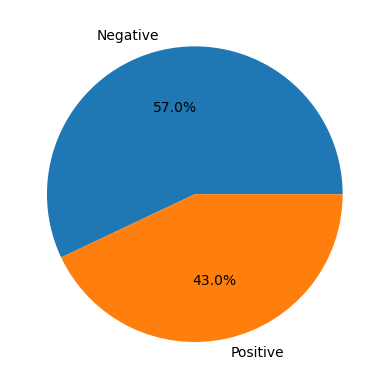

In [15]:
label_count = data_train['target'].value_counts()
labels = ['Negative', 'Positive']

plt.pie(label_count, labels=labels, autopct='%1.1f%%')

print(f"Non-Disaster Tweet Count = {label_count[0]}")
print(f"Disaster Tweet Count = {label_count[1]}")

plt.show()

There do appear to be many duplicates for Tweets in the training dataframe. Let us take a look at some of these duplicates.

In [16]:
data_train[data_train.text.duplicated() == True]

,id,keyword,location,text,target
48,68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
115,165,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
119,172,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0
164,238,airplane%20accident,NaN,Experts in France begin examining airplane deb...,1
624,898,bioterrorism,NaN,To fight bioterrorism sir.,0
630,907,bioterrorism,NaN,To fight bioterrorism sir.,1
634,916,bioterrorism,NaN,To fight bioterrorism sir.,0
1156,1665,bombing,Singapore,Japan on Thursday marks the 70th anniversary o...,1
1251,1807,buildings%20on%20fire,UK,#TweetLikeItsSeptember11th2001 Those two build...,1
1331,1922,burning%20buildings,"Mackay, QLD, Australia",Mmmmmm I'm burning.... I'm burning buildings I...,0


Observing the duplicate data, here are some key points:

* Some of the duplicate Tweets are labelled both positively and negatively.
* However, in these duplicates with differing labels, the keywords are always the same.
* Location does not appear to have any obvious relevance.

Thus, we will not need "location", "keyword" and "id" (since it appears to be redundant) in our model. However, we will not remove them from the train dataframe. This will be taken care of when we tokenize the train "text" data.

##  Part 3: Model Architecture

Before building our model, we will need to prepoare the data. First we will do some text cleaning:
    
* Remove non-English characters
* Convert to lower case
* Remove white spaces
* Remove the most common words (like articles, prepositions, pronouns, conjunctions, etc) that do not add much information to the text (ie. stop words) 
* Remove suffixes from words (ie. stemming)

In [21]:
def text_cleaner(var):
    sw = set(stopwords.words('english'))
    ps = PorterStemmer() 

    # tokenize the word using nltk  
    my_text = nltk.word_tokenize(var)

    # remove not english characters, lower case and remove the white space at end 
    my_text = re.sub('[^A-Za-z0-9]+', " ", var).lower().strip()

    # remove stop words 
    my_text = [word for word in my_text.split() if word not in sw]

    # stemming
    my_text = [ps.stem(word) for word in my_text]

    # convert back to sentence
    my_text = ' '.join(my_text)

    return my_text

In [22]:
data_train['text'] = data_train['text'].apply(text_cleaner)
data_train.head()

,text,target
0,deed reason earthquak may allah forgiv us,1
1,forest fire near la rong sask canada,1
2,resid ask shelter place notifi offic evacu she...,1
3,13 000 peopl receiv wildfir evacu order califo...,1
4,got sent photo rubi alaska smoke wildfir pour ...,1


Tokenizing is the process of changing words into integers. This will aid in the data processing.

In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_train.text.values)
data_train['tokenized'] = tokenizer.texts_to_sequences(data_train.text.values)

In [24]:
data_train.head()

,text,target,tokenized
0,deed reason earthquak may allah forgiv us,1,"[3848, 497, 229, 99, 1424, 3065, 44]"
1,forest fire near la rong sask canada,1,"[152, 4, 201, 592, 5577, 5578, 1088]"
2,resid ask shelter place notifi offic evacu she...,1,"[1425, 551, 1726, 425, 5579, 230, 39, 1726, 42..."
3,13 000 peopl receiv wildfir evacu order califo...,1,"[696, 2570, 12, 2571, 113, 39, 334, 48]"
4,got sent photo rubi alaska smoke wildfir pour ...,1,"[62, 1089, 149, 3849, 1556, 226, 113, 2572, 138]"


We will now begin to create our "X" training set. We will begin by creating a separate copy of the tokenized column.

In [25]:
data_train_token = data_train.tokenized
data_train_token

0                    [3848, 497, 229, 99, 1424, 3065, 44]
1                    [152, 4, 201, 592, 5577, 5578, 1088]
2       [1425, 551, 1726, 425, 5579, 230, 39, 1726, 42...
3                 [696, 2570, 12, 2571, 113, 39, 334, 48]
4        [62, 1089, 149, 3849, 1556, 226, 113, 2572, 138]
                              ...                        
7608    [69, 719, 1067, 560, 329, 57, 590, 33, 2, 1, 1...
7609    [5554, 5555, 5556, 517, 254, 4, 48, 104, 166, ...
7610    [2491, 2162, 612, 1080, 1412, 1413, 442, 1414,...
7611    [32, 187, 491, 2075, 127, 58, 253, 4446, 491, ...
7612    [188, 33, 424, 166, 48, 113, 587, 14, 2, 1, 18...
Name: tokenized, Length: 7613, dtype: object

We will next add padding to each token sequence. Zeroes are added to the endo of each sequence to normalize the length of each tokenized text string.

In [26]:
data_train_token = pad_sequences(data_train_token, maxlen = 50, padding = 'post')
data_train_token

array([[3848,  497,  229, ...,    0,    0,    0],
       [ 152,    4,  201, ...,    0,    0,    0],
       [1425,  551, 1726, ...,    0,    0,    0],
       ...,
       [2491, 2162,  612, ...,    0,    0,    0],
       [  32,  187,  491, ...,    0,    0,    0],
       [ 188,   33,  424, ...,    0,    0,    0]], dtype=int32)

Before building the model, we will divide the training dataset into a training and validation set.

In [27]:
x_train, x_val, y_train, y_val = train_test_split(data_train_token, data_train.target.values, test_size = 0.2, random_state=56)

Let us take a look at the shapes of both x_train and y_train.

In [28]:
x_train.shape

(6090, 50)

In [29]:
y_train.shape

(6090,)

We will need to reshape both y_train and y_val.

In [30]:
y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))
y_train.shape

(6090, 1)

We will now the word word-to-integer mapping.

In [32]:
word2idx = tokenizer.word_index
num_words = len(tokenizer.word_index)
print('Found %s unique tokens.' % num_words)

Found 18432 unique tokens.


### Model 1

For our model, we will implement Long Short-Term Memory (LSTM) model. Below is a brief summary of why a LSTM should be used:

Due to the transformations that the data goes through when traversing an RNN, some information is lost at each time step. After a while, the RNN’s state contains virtually no trace of the first inputs. To tackle this problem, various types of models with long-term memory have been introduced, such as the LSTM. In short, an LSTM cell can learn to recognize an important input, store it in the long-term state, preserve it for as long as it is needed, and extract it whenever it is needed. This explains why these cells have been amazingly successful at capturing long-term patterns.

To begin, we will implement a very simple model as shown below:

Input -> LSTM -> LSTM -> Dense (ReLU) -> Dense (Sigmoid)

In [33]:
model1 = Sequential()

model1.add(Embedding(input_dim = num_words, output_dim = 32, input_length = 50))

model1.add(LSTM(64, return_sequences=True))

model1.add(LSTM(32))

model1.add(Dense(units = 24, activation = 'relu'))

model1.add(Dense(units = 1, activation = 'sigmoid'))

'''
We do not need to specify the length of the input sequences since a recurrent neural network can 
process any number of time steps. This is why we set the first input shape dimension to
"None".
'''
model1.build(input_shape = (None, 50))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            589824    
                                                                 
 lstm (LSTM)                 (None, 50, 64)            24832     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 627,889
Trainable params: 627,889
Non-trainable params: 0
_________________________________________________________________


Model1 will use Adam optimization (with default values) and binary cross-entropy for loss. Training will occur over 15 epochs.

In [34]:
opt = Adam()
model1_epochs = 15

model1.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
startTime1 = time.time()
history1 = model1.fit(x_train, y_train, epochs = model1_epochs, validation_data = [x_val, y_val])
endTime1 = time.time()

Epoch 1/15
191/191 [==============================] - 17s 63ms/step - loss: 0.6422 - accuracy: 0.6302 - val_loss: 0.5277 - val_accuracy: 0.7840
Epoch 2/15
191/191 [==============================] - 11s 58ms/step - loss: 0.4628 - accuracy: 0.8245 - val_loss: 0.5145 - val_accuracy: 0.7873
Epoch 3/15
191/191 [==============================] - 11s 57ms/step - loss: 0.4281 - accuracy: 0.8411 - val_loss: 0.5943 - val_accuracy: 0.7400
Epoch 4/15
191/191 [==============================] - 11s 58ms/step - loss: 0.4524 - accuracy: 0.8143 - val_loss: 0.6025 - val_accuracy: 0.7663
Epoch 5/15
191/191 [==============================] - 11s 60ms/step - loss: 0.4401 - accuracy: 0.8220 - val_loss: 0.5676 - val_accuracy: 0.7177
Epoch 6/15
191/191 [==============================] - 12s 61ms/step - loss: 0.4395 - accuracy: 0.8218 - val_loss: 0.5298 - val_accuracy: 0.7794
Epoch 7/15
191/191 [==============================] - 11s 59ms/step - loss: 0.3974 - accuracy: 0.8506 - val_loss: 0.5264 - val_accuracy:

Now let us take a look at the results from model1.

The final results for model 1:

Training Time = 2.933 minutes
Accuracy = 0.935
Loss = 0.238
Validation Accuracy = 0.765
Validation Loss = 0.68




<function matplotlib.pyplot.show(close=None, block=None)>

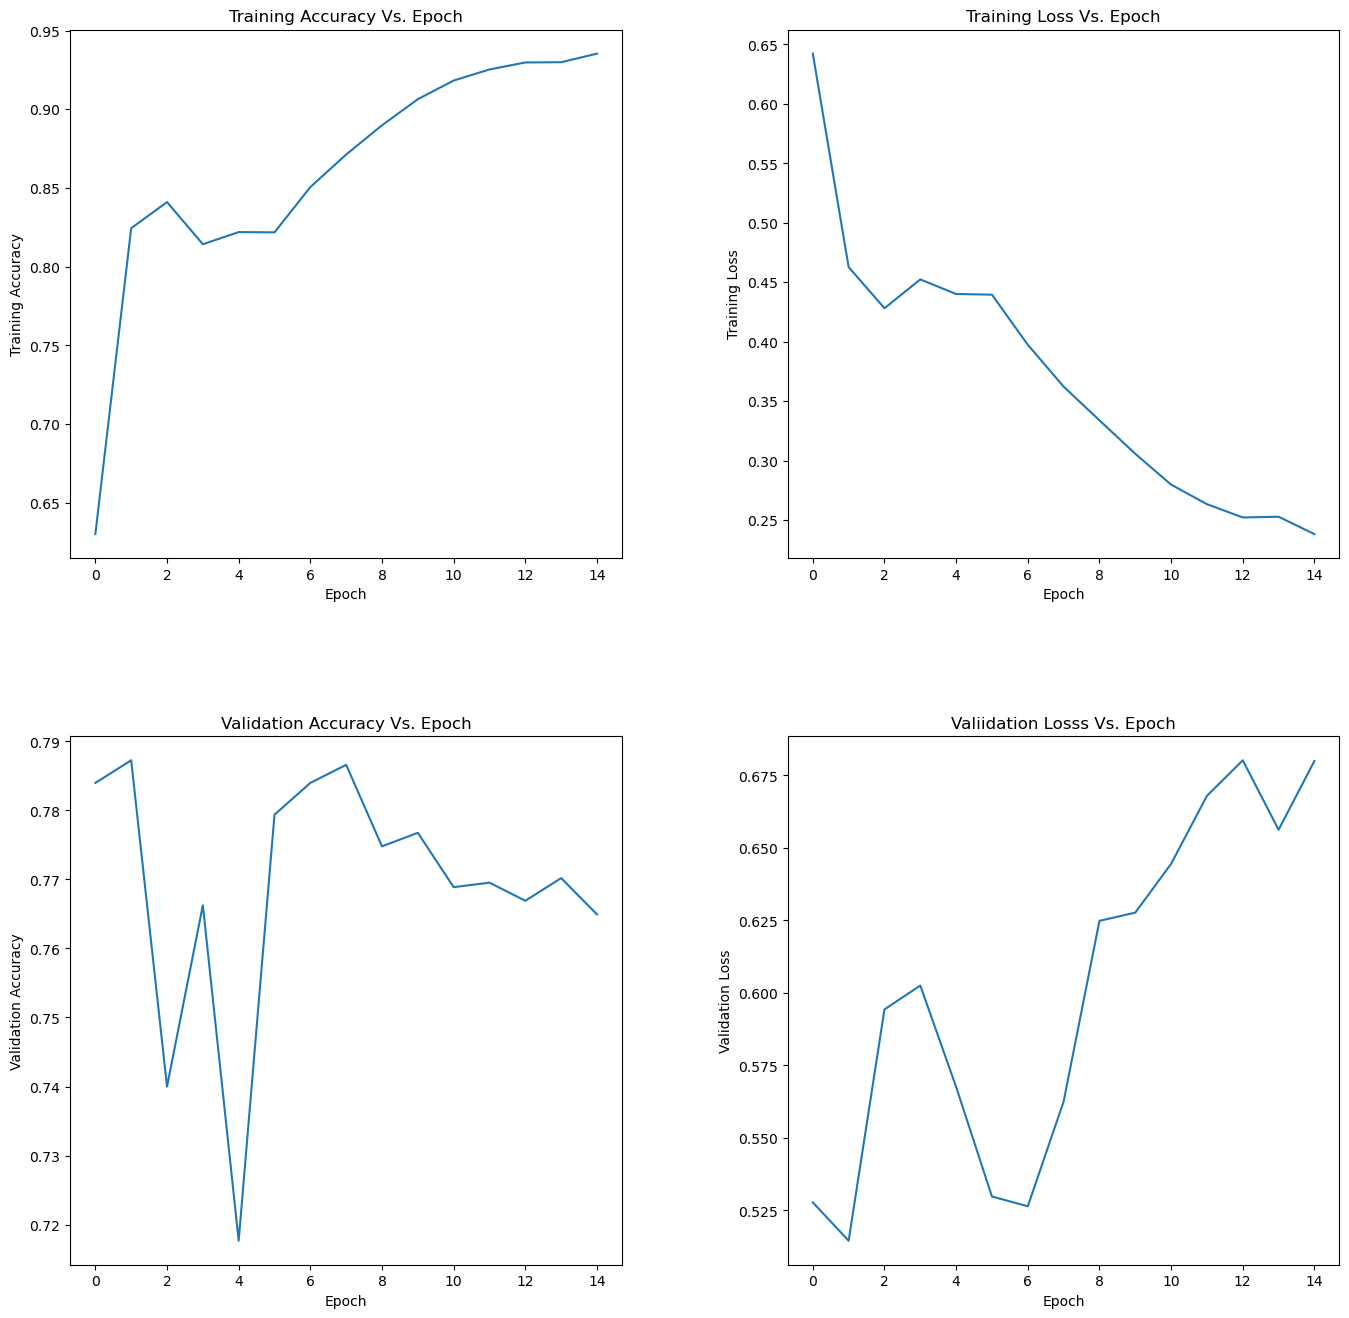

In [36]:
model1_accuracy = round((history1.history["accuracy"][model1_epochs - 1]), 3)
model1_loss = round((history1.history["loss"][model1_epochs - 1]), 3)
model1_val_accuracy = round((history1.history["val_accuracy"][model1_epochs - 1]), 3)
model1_val_loss = round((history1.history["val_loss"][model1_epochs - 1]), 3)
model1_train_time = round((endTime1 - startTime1) / 60, 3)

print("The final results for model 1:")
print(f"\nTraining Time = {model1_train_time} minutes")
print(f"Accuracy = {model1_accuracy}")
print(f"Loss = {model1_loss}")
print(f"Validation Accuracy = {model1_val_accuracy}")
print(f"Validation Loss = {model1_val_loss}\n\n")

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2)
figure.tight_layout(pad = 2)
figure.set_figheight(15)
figure.set_figwidth(15)

# Make a nice visualization of our test model: Training Accuracy Vs. Epoch
testAccs = history1.history["accuracy"]
epochs = [i for i in range(len(testAccs))]
axis[0, 0].plot(epochs, testAccs)
axis[0, 0].set_xlabel("Epoch")
axis[0, 0].set_ylabel("Training Accuracy")
axis[0, 0].set_title("Training Accuracy Vs. Epoch")

# Make another nice visualization: Loss Vs. Epoch
testLosses = history1.history["loss"]
axis[0, 1].plot(epochs, testLosses)
axis[0, 1].set_xlabel("Epoch")
axis[0, 1].set_ylabel("Training Loss")
axis[0, 1].set_title("Training Loss Vs. Epoch")

# Make a nice visualization of our test model: Validation Accuracy Vs. Epoch
testAccs = history1.history["val_accuracy"]
epochs = [i for i in range(len(testAccs))]
axis[1, 0].plot(epochs, testAccs)
axis[1, 0].set_xlabel("Epoch")
axis[1, 0].set_ylabel("Validation Accuracy")
axis[1, 0].set_title("Validation Accuracy Vs. Epoch")

# Make another nice visualization: Loss Vs. Epoch
testLosses = history1.history["val_loss"]
axis[1, 1].plot(epochs, testLosses)
axis[1, 1].set_xlabel("Epoch")
axis[1, 1].set_ylabel("Validation Loss")
axis[1, 1].set_title("Valiidation Losss Vs. Epoch")

plt.show

Looking at the results of model1, note the below observations:

* The results for both the training accuracy and training loss seem to at least on the surface give reason for optimmism. Accuracy steadily increases to a final value of 93.5%. Training loss is also steadily decreasing.
* However the results on the validation set appear troubling. The validation accuracy seems to hover around 75%. Validation loss is steadily increasing.
* Given the resuults of training versus validation, the model appears to be overfitting the training dataset.

### Model 2

Let us attempt to rectify the issue of overfitting with the second model. Below are the key changes:

* Batch normalization layers have been added at the end of each LSTM cell. The batch normalization layer should help prevent overfitting.
* A dropout layers have been added to the ANN beteen the two dense layers. 
* At the beginnning of the ANN, a flatten layer has been added.

In [37]:
model2 = Sequential()

model2.add(Embedding(input_dim = num_words, output_dim = 32, input_length = 50))

model2.add(LSTM(64, return_sequences = True))

# Normalize to prevent overfitting
model2.add(BatchNormalization())

model2.add(LSTM(32))

# Normalize to prevent overfitting
model2.add(BatchNormalization())

model2.add(Flatten())

model2.add(Dense(units = 24, activation = 'relu'))

# Dropout layer randomly sets input units to 0 which helps prevent overfitting
model2.add(Dropout(0.25))
    
model2.add(Dense(units = 1, activation = 'sigmoid'))

'''
We do not need to specify the length of the input sequences since a recurrent neural network can 
process any number of time steps. This is why we set the first input shape dimension to
"None".
'''
model2.build(input_shape=(None, 50))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 32)            589824    
                                                                 
 lstm_2 (LSTM)               (None, 50, 64)            24832     
                                                                 
 batch_normalization (BatchN  (None, 50, 64)           256       
 ormalization)                                                   
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 32)               

Model2 will continue to use Adam optimization (with default values) and binary cross-entropy for loss. Training will again occur over 15 epochs.

In [38]:
opt = Adam()
model2_epochs = 15

model2.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [39]:
startTime2 = time.time()
history2 = model2.fit(x_train, y_train, epochs = model2_epochs, validation_data = [x_val, y_val])
endTime2 = time.time()

Epoch 1/15
191/191 [==============================] - 20s 82ms/step - loss: 0.5429 - accuracy: 0.7356 - val_loss: 0.6851 - val_accuracy: 0.6415
Epoch 2/15
191/191 [==============================] - 15s 79ms/step - loss: 0.2984 - accuracy: 0.8869 - val_loss: 0.8246 - val_accuracy: 0.5955
Epoch 3/15
191/191 [==============================] - 14s 76ms/step - loss: 0.1684 - accuracy: 0.9447 - val_loss: 0.5506 - val_accuracy: 0.7892
Epoch 4/15
191/191 [==============================] - 14s 75ms/step - loss: 0.1148 - accuracy: 0.9611 - val_loss: 0.9157 - val_accuracy: 0.7820
Epoch 5/15
191/191 [==============================] - 15s 77ms/step - loss: 0.0764 - accuracy: 0.9773 - val_loss: 0.5139 - val_accuracy: 0.7584
Epoch 6/15
191/191 [==============================] - 14s 73ms/step - loss: 0.0591 - accuracy: 0.9818 - val_loss: 1.4463 - val_accuracy: 0.6369
Epoch 7/15
191/191 [==============================] - 14s 74ms/step - loss: 0.0645 - accuracy: 0.9814 - val_loss: 0.9361 - val_accuracy:

Now let us take a look at the results from model1.

The final results for model 1:

Training Time = 3.73 minutes
Accuracy = 0.992
Loss = 0.021
Validation Accuracy = 0.781
Validation Loss = 1.35




<function matplotlib.pyplot.show(close=None, block=None)>

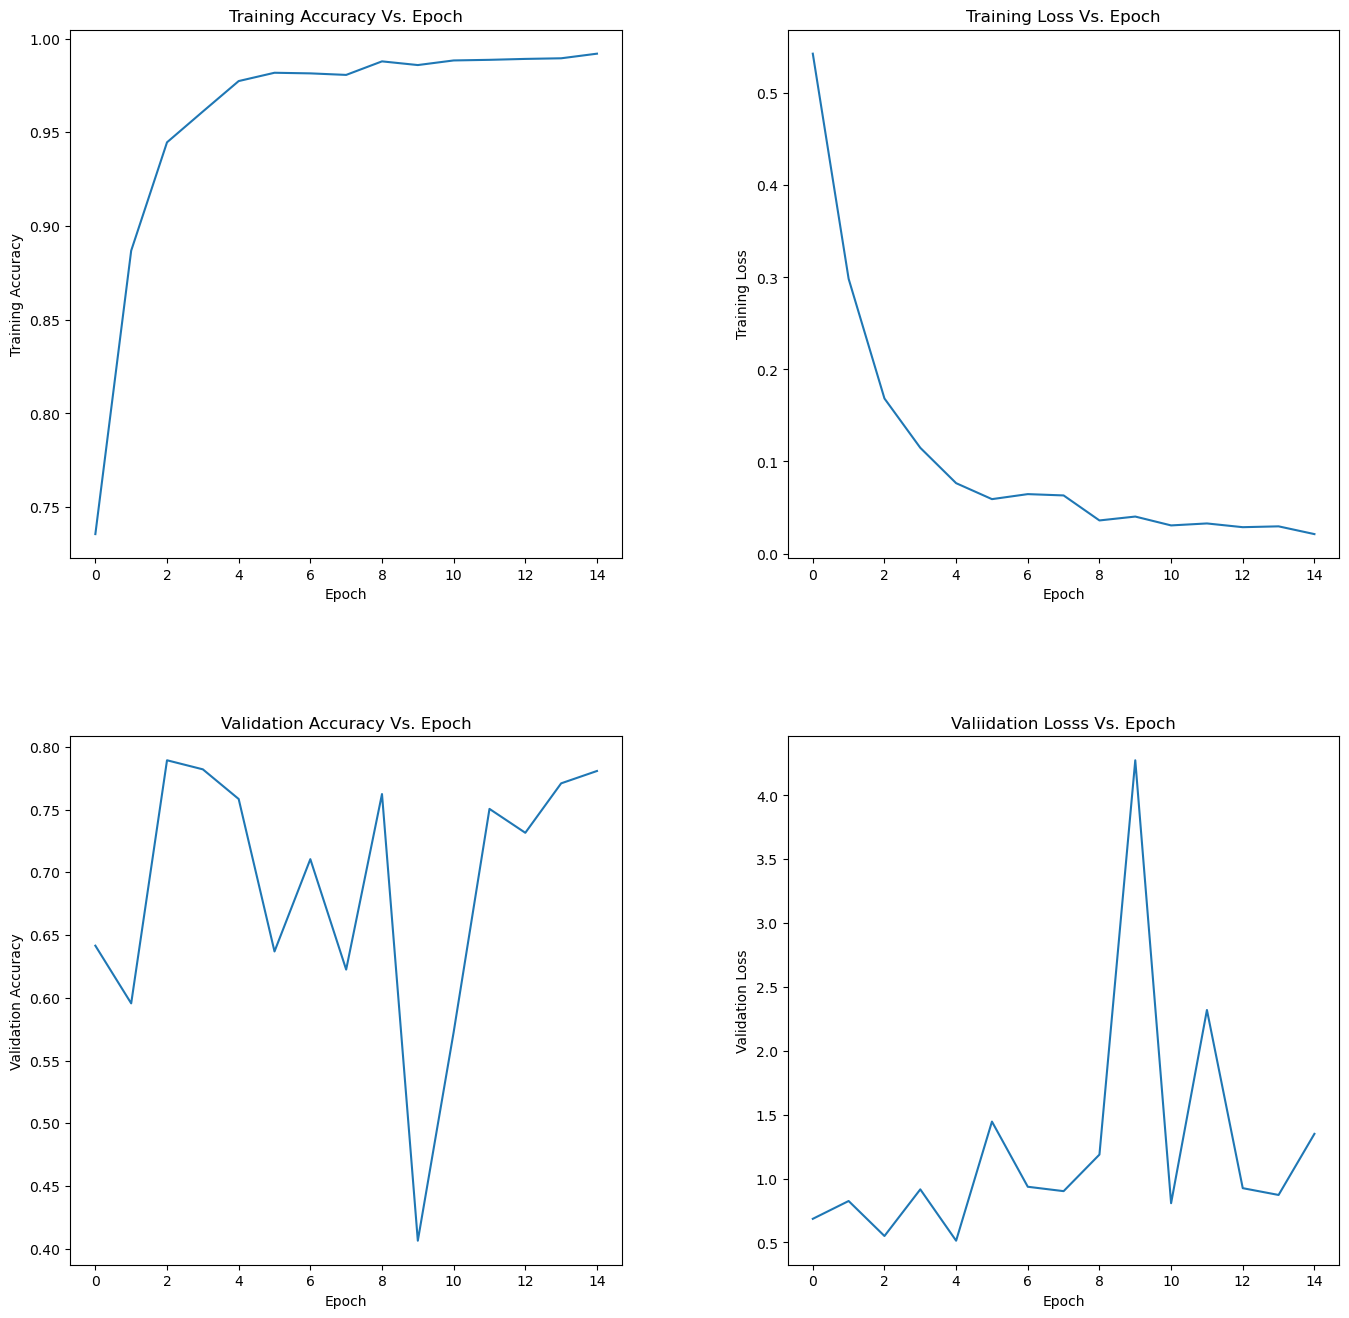

In [40]:
model2_accuracy = round((history2.history["accuracy"][model2_epochs - 1]), 3)
model2_loss = round((history2.history["loss"][model2_epochs - 1]), 3)
model2_val_accuracy = round((history2.history["val_accuracy"][model2_epochs - 1]), 3)
model2_val_loss = round((history2.history["val_loss"][model2_epochs - 1]), 3)
model2_train_time = round((endTime2 - startTime2) / 60, 3)

print("The final results for model 1:")
print(f"\nTraining Time = {model2_train_time} minutes")
print(f"Accuracy = {model2_accuracy}")
print(f"Loss = {model2_loss}")
print(f"Validation Accuracy = {model2_val_accuracy}")
print(f"Validation Loss = {model2_val_loss}\n\n")

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2)
figure.tight_layout(pad = 2)
figure.set_figheight(15)
figure.set_figwidth(15)

# Make a nice visualization of our test model: Training Accuracy Vs. Epoch
testAccs = history2.history["accuracy"]
epochs = [i for i in range(len(testAccs))]
axis[0, 0].plot(epochs, testAccs)
axis[0, 0].set_xlabel("Epoch")
axis[0, 0].set_ylabel("Training Accuracy")
axis[0, 0].set_title("Training Accuracy Vs. Epoch")

# Make another nice visualization: Loss Vs. Epoch
testLosses = history2.history["loss"]
axis[0, 1].plot(epochs, testLosses)
axis[0, 1].set_xlabel("Epoch")
axis[0, 1].set_ylabel("Training Loss")
axis[0, 1].set_title("Training Loss Vs. Epoch")

# Make a nice visualization of our test model: Validation Accuracy Vs. Epoch
testAccs = history2.history["val_accuracy"]
epochs = [i for i in range(len(testAccs))]
axis[1, 0].plot(epochs, testAccs)
axis[1, 0].set_xlabel("Epoch")
axis[1, 0].set_ylabel("Validation Accuracy")
axis[1, 0].set_title("Validation Accuracy Vs. Epoch")

# Make another nice visualization: Loss Vs. Epoch
testLosses = history2.history["val_loss"]
axis[1, 1].plot(epochs, testLosses)
axis[1, 1].set_xlabel("Epoch")
axis[1, 1].set_ylabel("Validation Loss")
axis[1, 1].set_title("Valiidation Losss Vs. Epoch")

plt.show

Model2 also appears to be overfitting the data. , note the below observations:

* The results for both the training accuracy and training loss are again very good. Accuracy steadily increases to a final value of 99.2%. Training loss is also steadily decreasing and reaches a very low loss value.
* The results on the validation set are again troubling. The validation accuracy is quite erratic but never gets higher than 78%. 
* Validation loss is generally good but you can observe a slow increase.

### Model 3

We will now attempt tune our model hyperparameters to potentially resolve our overfitting issues. The below two parameters will be tuned in the model:

* Initial Learning Rate (eta)
* Decay Rate
* Optimizers (Adam, RMSprop)

The hyperparameter tuning will be run for a lower number of epochs than models 1 and 2. This will be 10 epochs.

In [41]:
model3 = Sequential()

model3.add(Embedding(input_dim = num_words, output_dim = 32, input_length = 50))

model3.add(LSTM(64, return_sequences=True))

# Normalize to prevent overfitting
model3.add(BatchNormalization())

model3.add(LSTM(32))

# Normalize to prevent overfitting
model3.add(BatchNormalization())

model3.add(Dense(units=24, activation='relu'))

# Dropout layer randomly sets input units to 0 which helps prevent overfitting
model3.add(Dropout(0.25))
    
model3.add(Dense(units=1, activation='sigmoid'))

'''
We do not need to specify the length of the input sequences since a recurrent neural network can 
process any number of time steps. This is why we set the first input shape dimension to
"None".
'''
model3.build(input_shape=(None, 50))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 32)            589824    
                                                                 
 lstm_4 (LSTM)               (None, 50, 64)            24832     
                                                                 
 batch_normalization_2 (Batc  (None, 50, 64)           256       
 hNormalization)                                                 
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 batch_normalization_3 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 24)               

Let us set up our testing hyperparameters.

In [43]:
eta_to_try = [0.0001, 0.001, 0.01]
decay_to_try = [0.99, 0.95, 0.90]

model3_epochs = 10

hpPermutations = list(itertools.product(*[eta_to_try, decay_to_try]))
current_best_model = (None, 0)
current_best_history = None
current_best_hp = None

model_accuracies = list()

Let us now do some automated testing to determine the best hyperparameters.

In [44]:
startTime3 = time.time()
for hpList in hpPermutations:
    print(f"\n\nNow trying hyperparams: learning rate = {hpList[0]}, decay_rate = {hpList[1]}, optimizer = Adam")
    this_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = hpList[0], decay_steps = 10000, decay_rate = hpList[1])
    # Make a learning rate schedule to prevent variance at the end of training.
    model3.compile(optimizer = Adam(learning_rate = this_lr_schedule), loss = 'binary_crossentropy', metrics = ['accuracy'])

    this_history = model3.fit(x_train, y_train, epochs = model3_epochs, validation_data=[x_val, y_val], callbacks = callbacks_list)
    if this_history.history["accuracy"][-1] > current_best_model[1]:
        current_best_model = (model3, this_history.history["accuracy"][-1])
        current_best_history = this_history.history
        current_best_hp = hpList

for hpList in hpPermutations:
    print(f"\n\nNow trying hyperparams: learning rate = {hpList[0]}, decay_rate = {hpList[1]}, optimizer = RMSprop")
    this_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = hpList[0], decay_steps = 10000, decay_rate = hpList[1])
    model3.compile(optimizer = RMSprop(learning_rate = this_lr_schedule), loss = 'binary_crossentropy', metrics = ['accuracy'])

    this_history = model3.fit(x_train, y_train, epochs = model3_epochs, validation_data=[x_val, y_val], callbacks = callbacks_list)
    if this_history.history["accuracy"][-1] > current_best_model[1]:
        current_best_model = (model3, this_history.history["accuracy"][-1])
        current_best_history = this_history.history
        current_best_hp = hpList
        
endTime3 = time.time()
print("Total HP optimization time:", round((endTime3 - startTime3) / 60, 3), "minutes")



Now trying hyperparams: learning rate = 0.0001, decay_rate = 0.99, optimizer = Adam
Epoch 1/10
191/191 [==============================] - 21s 86ms/step - loss: 0.6477 - accuracy: 0.6230 - val_loss: 0.6762 - val_accuracy: 0.5936
Epoch 2/10
191/191 [==============================] - 15s 79ms/step - loss: 0.4956 - accuracy: 0.7650 - val_loss: 0.9394 - val_accuracy: 0.4064
Epoch 3/10
191/191 [==============================] - 15s 76ms/step - loss: 0.3688 - accuracy: 0.8463 - val_loss: 0.5252 - val_accuracy: 0.7682
Epoch 4/10
191/191 [==============================] - 15s 79ms/step - loss: 0.2757 - accuracy: 0.8975 - val_loss: 0.8405 - val_accuracy: 0.7387
Epoch 5/10
191/191 [==============================] - 15s 76ms/step - loss: 0.1966 - accuracy: 0.9312 - val_loss: 3.3082 - val_accuracy: 0.5955
Epoch 6/10
191/191 [==============================] - 15s 78ms/step - loss: 0.1438 - accuracy: 0.9521 - val_loss: 7.1347 - val_accuracy: 0.4064
Epoch 7/10
191/191 [==============================

Most of the hyperparameters we tested yield similar results. 

In [45]:
best_model_acc = round(current_best_model[1], 3)

print(f"The accuracy of the best hyperparameters is {best_model_acc}%")

The accuracy of the best hyperparameters is 0.995%


In [46]:
current_best_hp

(0.001, 0.9)

### Model 4: Final Model

We will now build the final model using the hyperparameters from the model 3 testing. It will be trained to a maximum of 90 epochs. Callbacks are implemented which may end training prior to the maximum.

* Optimizer = Adam
* Initial Learning Rate = 0.001
* Decay Rate = 0.90

In [47]:
model4 = Sequential()

model4.add(Embedding(input_dim = num_words, output_dim = 32, input_length = 50))

model4.add(LSTM(64, return_sequences=True))

# Normalize to prevent overfitting
model4.add(BatchNormalization())

model4.add(LSTM(32))

# Normalize to prevent overfitting
model4.add(BatchNormalization())

model4.add(Dense(units=24, activation='relu'))

# Dropout layer randomly sets input units to 0 which helps prevent overfitting
model4.add(Dropout(0.25))
    
model4.add(Dense(units=1, activation='sigmoid'))

'''
We do not need to specify the length of the input sequences since a recurrent neural network can 
process any number of time steps. This is why we set the first input shape dimension to
"None".
'''
model4.build(input_shape=(None, 50))

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 32)            589824    
                                                                 
 lstm_6 (LSTM)               (None, 50, 64)            24832     
                                                                 
 batch_normalization_4 (Batc  (None, 50, 64)           256       
 hNormalization)                                                 
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 24)               

In [50]:
callbacks_list =  [tf.keras.callbacks.EarlyStopping(monitor = "loss", patience = 10, mode = "min")]
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.001, decay_steps = 10000, decay_rate = 0.90)

opt = Adam(learning_rate = lr_schedule)
model4_epochs = 90

model4.compile(optimizer = opt, loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
startTime4 = time.time()
history4 = model4.fit(x_train, y_train, epochs = model4_epochs, validation_data = [x_val, y_val], callbacks = callbacks_list)
endTime4 = time.time()

Epoch 1/90
191/191 [==============================] - 19s 80ms/step - loss: 0.0989 - accuracy: 0.9673 - val_loss: 28.7135 - val_accuracy: 0.4064
Epoch 2/90
191/191 [==============================] - 15s 77ms/step - loss: 0.0926 - accuracy: 0.9685 - val_loss: 12.1470 - val_accuracy: 0.5936
Epoch 3/90
191/191 [==============================] - 14s 74ms/step - loss: 0.0761 - accuracy: 0.9741 - val_loss: 6.0551 - val_accuracy: 0.5942
Epoch 4/90
191/191 [==============================] - 15s 77ms/step - loss: 0.0644 - accuracy: 0.9785 - val_loss: 1.7911 - val_accuracy: 0.6645
Epoch 5/90
191/191 [==============================] - 15s 80ms/step - loss: 0.0585 - accuracy: 0.9814 - val_loss: 7.5128 - val_accuracy: 0.5942
Epoch 6/90
191/191 [==============================] - 16s 82ms/step - loss: 0.0468 - accuracy: 0.9841 - val_loss: 2.7194 - val_accuracy: 0.4347
Epoch 7/90
191/191 [==============================] - 15s 80ms/step - loss: 0.0408 - accuracy: 0.9882 - val_loss: 26.1404 - val_accura

## Part 4: Results and Analysis

We will now observe the final results.

The final results for model 4:

Training Time = 7.924 minutes
Accuracy = 0.996
Loss = 0.01
Validation Accuracy = 0.776
Validation Loss = 2.039




<function matplotlib.pyplot.show(close=None, block=None)>

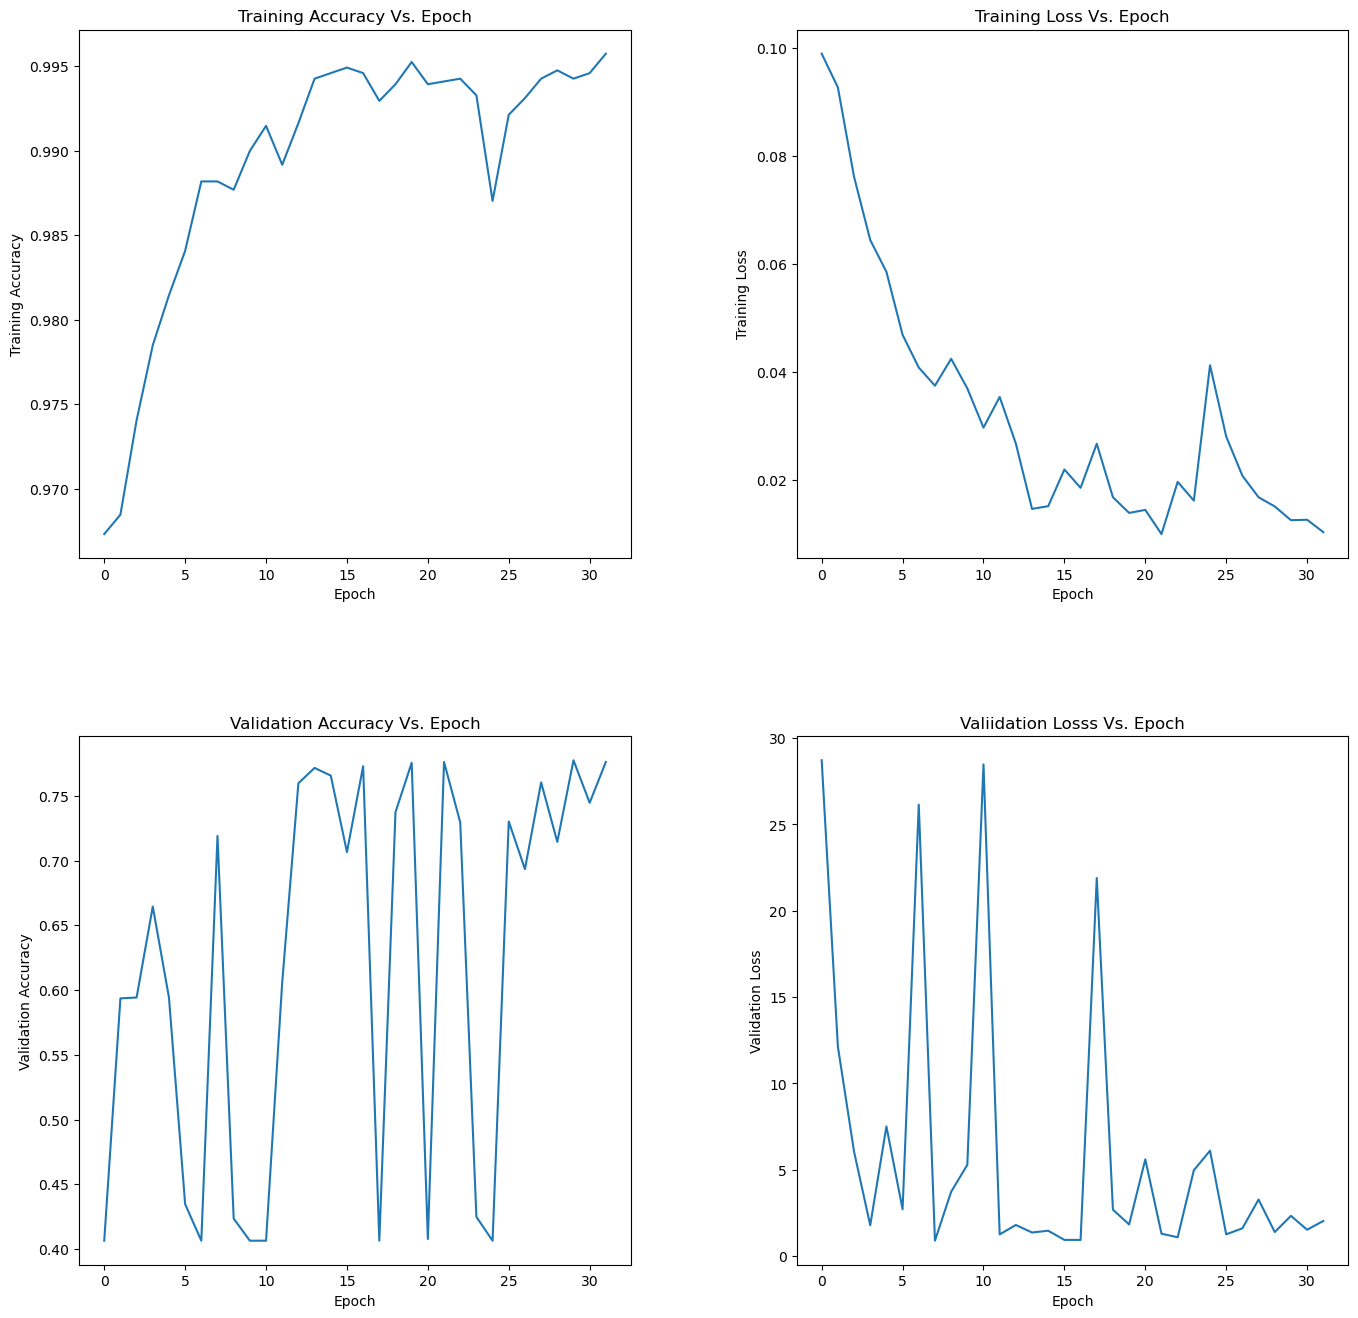

In [52]:
used_epochs = len(history4.history["accuracy"])

model4_accuracy = round((history4.history["accuracy"][used_epochs - 1]), 3)
model4_loss = round((history4.history["loss"][used_epochs - 1]), 3)
model4_val_accuracy = round((history4.history["val_accuracy"][used_epochs - 1]), 3)
model4_val_loss = round((history4.history["val_loss"][used_epochs - 1]), 3)
model4_train_time = round((endTime4 - startTime4) / 60, 3)

print("The final results for model 4:")
print(f"\nTraining Time = {model4_train_time} minutes")
print(f"Accuracy = {model4_accuracy}")
print(f"Loss = {model4_loss}")
print(f"Validation Accuracy = {model4_val_accuracy}")
print(f"Validation Loss = {model4_val_loss}\n\n")

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2)
figure.tight_layout(pad = 2)
figure.set_figheight(15)
figure.set_figwidth(15)

# Make a nice visualization of our test model: Training Accuracy Vs. Epoch
testAccs = history4.history["accuracy"]
epochs = [i for i in range(len(testAccs))]
axis[0, 0].plot(epochs, testAccs)
axis[0, 0].set_xlabel("Epoch")
axis[0, 0].set_ylabel("Training Accuracy")
axis[0, 0].set_title("Training Accuracy Vs. Epoch")

# Make another nice visualization: Loss Vs. Epoch
testLosses = history4.history["loss"]
axis[0, 1].plot(epochs, testLosses)
axis[0, 1].set_xlabel("Epoch")
axis[0, 1].set_ylabel("Training Loss")
axis[0, 1].set_title("Training Loss Vs. Epoch")

# Make a nice visualization of our test model: Validation Accuracy Vs. Epoch
testAccs = history4.history["val_accuracy"]
epochs = [i for i in range(len(testAccs))]
axis[1, 0].plot(epochs, testAccs)
axis[1, 0].set_xlabel("Epoch")
axis[1, 0].set_ylabel("Validation Accuracy")
axis[1, 0].set_title("Validation Accuracy Vs. Epoch")

# Make another nice visualization: Loss Vs. Epoch
testLosses = history4.history["val_loss"]
axis[1, 1].plot(epochs, testLosses)
axis[1, 1].set_xlabel("Epoch")
axis[1, 1].set_ylabel("Validation Loss")
axis[1, 1].set_title("Valiidation Losss Vs. Epoch")

plt.show

The final tuned model seems to mimic the results of the earlier attempts:

* The accuracy on the training set is nearly 100%.
* The validation accuracy and loss is quite erratic again. 
* This model is likely overfitting the training data.

## Part 5: Conclusion

In conclusion, we can assume this model will not do well when submitting the predictions to Kaggle. It appears to have significant issues with overfitting the data. Potential reasons for this issue could be:

* Only using the Tweets to train the model. We did not make use of the "keyword" or "location" categories in building our model.
* Faults in the data processing of the Tweets. Possibly too much context is lost.
* The model is overly simple. It is only two layers deep.

In [53]:
# tokenize the test dataset like we did for the training set
test_token = tokenizer.texts_to_sequences(data_test.text.values)
test_token = pad_sequences(test_token, maxlen = 50, padding = 'post')
test_token

array([[   58,    21,     0, ...,     0,     0,     0],
       [  430, 11131,   434, ...,     0,     0,     0],
       [ 1817,   152,     4, ...,     0,     0,     0],
       ...,
       [  816,   525,   801, ...,     0,     0,     0],
       [ 5140,   240,  1552, ...,     0,     0,     0],
       [   86,  3710,     0, ...,     0,     0,     0]], dtype=int32)

In [54]:
predictions = model4.predict(test_token)
predictions

102/102 [==============================] - 3s 18ms/step


array([[1.2280466e-06],
       [2.3314995e-03],
       [9.9496484e-01],
       ...,
       [2.3568012e-02],
       [9.8901892e-01],
       [1.5734142e-05]], dtype=float32)

In [55]:
pred = np.transpose(predictions)[0]
pred

array([1.2280466e-06, 2.3314995e-03, 9.9496484e-01, ..., 2.3568012e-02,
       9.8901892e-01, 1.5734142e-05], dtype=float32)

In [56]:
submission_df = pd.DataFrame()
submission_df['id'] = data_test['id']
submission_df['target'] = list(map(lambda x: 0 if x < 0.5 else 1, pred))
submission_df.head()

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1


In [57]:
submission_df['target'].value_counts()

0    2721
1     542
Name: target, dtype: int64

In [58]:
submission_df.to_csv('submission.csv', index=False)

##  Part 6: Reference

* https://www.kaggle.com/code/priteshpatel25/beginners-nlp-disastertweetss
* https://www.tensorflow.org/guide/keras/rnn
* https://www.kaggle.com/code/mertyldrr/stacked-lstm-tensorflow-2-beginner